# Developing "Momentum" Trading Strategy
* Many differnt takes on this strategy
* Sometimes referred to as trend following
* Whatever you do and call it, you first need to research potential trading signals

In [ ]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt


### 1. Download data: 
* Many services for this, some paid some free 
* Yahoo Finance API
* Typically trading "systems" involve a number of securities
* For this demonstration we are just going to look at GLD --> the gold ETF

In [ ]:
from google.colab import files
uploaded =  files.upload()

Saving AAPL.csv to AAPL.csv


In [ ]:
gld = pd.read_csv('AAPL.csv')
day = np.arange(1, len(gld) + 1)
gld['day'] = day
gld.drop(columns=['Adj Close', 'Volume'], inplace = True)
gld = gld[['day', 'Open', 'High', 'Low', 'Close']]
gld.head()

,day,Open,High,Low,Close
0,1,27.847500,27.860001,26.837500,27.332500
1,2,27.072500,27.162500,26.352501,26.562500
2,3,26.635000,26.857500,26.157499,26.565001
3,4,26.799999,27.049999,26.674999,26.937500
4,5,27.307501,28.037500,27.174999,27.972500


In [ ]:
gld.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1841 entries, 0 to 1840
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     1841 non-null   int64  
 1   Open    1841 non-null   float64
 2   High    1841 non-null   float64
 3   Low     1841 non-null   float64
 4   Close   1841 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 72.0 KB


### 2. Add data/transform data
* calculate signal based on some price or statistical action
* we are going to try a moving average crossover to generate signals
* for this strategy we will always by "in" a trade, either long or short
* we are modeling; this means real life variation should be expected

#### Add moving averages to the data frame

In [ ]:
gld['9-day'] = gld['Close'].rolling(9).mean()
gld['21-day'] = gld['Close'].rolling(21).mean()
gld[19:25]

,day,Open,High,Low,Close,9-day,21-day
19,20,29.600000,30.000000,29.212500,29.290001,28.257222,NaN
20,21,29.512501,29.792500,29.020000,29.657499,28.532500,27.755476
21,22,29.625000,29.772499,29.402500,29.662500,28.785278,27.866429
22,23,29.625000,30.127501,29.577499,29.889999,28.984167,28.024881
23,24,30.004999,30.057501,29.812500,29.985001,29.177500,28.187738
24,25,30.004999,30.062500,29.612499,29.732500,29.339444,28.320833


#### Add "signal" column  

In [ ]:
gld['signal'] = np.where(gld['9-day'] > gld['21-day'], 1, 0)
gld['signal'] = np.where(gld['9-day'] < gld['21-day'], -1, gld['signal'])
gld.dropna(inplace=True)
gld.head()

,day,Open,High,Low,Close,9-day,21-day,signal
20,21,29.512501,29.792500,29.020000,29.657499,28.532500,27.755476,1
21,22,29.625000,29.772499,29.402500,29.662500,28.785278,27.866429,1
22,23,29.625000,30.127501,29.577499,29.889999,28.984167,28.024881,1
23,24,30.004999,30.057501,29.812500,29.985001,29.177500,28.187738,1
24,25,30.004999,30.062500,29.612499,29.732500,29.339444,28.320833,1


#### Calculate Instantaneous returns/system returns

In [ ]:
gld['return'] = np.log(gld['Close']).diff()
gld['system_return'] = gld['signal'] * gld['return']
gld['entry'] = gld.signal.diff()
gld.head()

,day,Open,High,Low,Close,9-day,21-day,signal,return,system_return,entry
20,21,29.512501,29.792500,29.020000,29.657499,28.532500,27.755476,1,NaN,NaN,NaN
21,22,29.625000,29.772499,29.402500,29.662500,28.785278,27.866429,1,0.000169,0.000169,0.0
22,23,29.625000,30.127501,29.577499,29.889999,28.984167,28.024881,1,0.007640,0.007640,0.0
23,24,30.004999,30.057501,29.812500,29.985001,29.177500,28.187738,1,0.003173,0.003173,0.0
24,25,30.004999,30.062500,29.612499,29.732500,29.339444,28.320833,1,-0.008457,-0.008457,0.0


#### Plot trades on time series

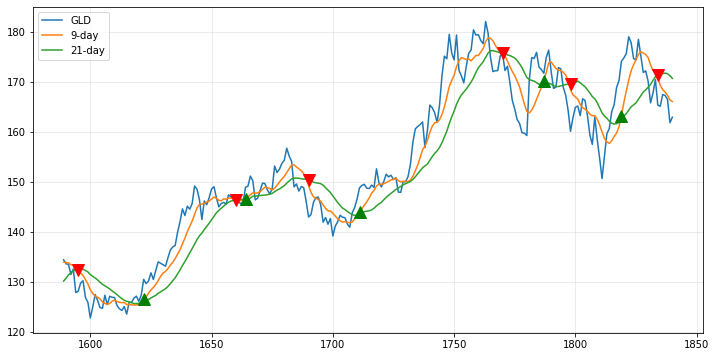

In [ ]:
plt.rcParams['figure.figsize'] = 12, 6
plt.grid(True, alpha = .3)
plt.plot(gld.iloc[-252:]['Close'], label = 'GLD')
plt.plot(gld.iloc[-252:]['9-day'], label = '9-day')
plt.plot(gld.iloc[-252:]['21-day'], label = '21-day')
plt.plot(gld[-252:].loc[gld.entry == 2].index, gld[-252:]['9-day'][gld.entry == 2], '^',
         color = 'g', markersize = 12)
plt.plot(gld[-252:].loc[gld.entry == -2].index, gld[-252:]['21-day'][gld.entry == -2], 'v',
         color = 'r', markersize = 12)
plt.legend(loc=2);

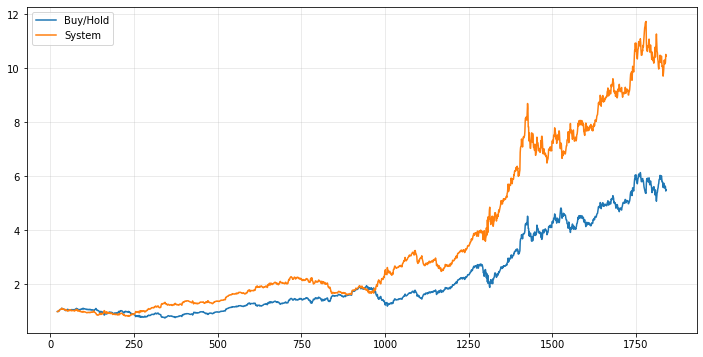

In [ ]:
plt.plot(np.exp(gld['return']).cumprod(), label='Buy/Hold')
plt.plot(np.exp(gld['system_return']).cumprod(), label='System')
plt.legend(loc=2)
plt.grid(True, alpha=.3)

In [ ]:
np.exp(gld['return']).cumprod()

20           NaN
21      1.000169
22      1.007840
23      1.011043
24      1.002529
          ...   
1836    5.644441
1837    5.638709
1838    5.611397
1839    5.455281
1840    5.492034
Name: return, Length: 1821, dtype: float64

In [ ]:
# print(np.exp(gld['system_return']).cumprod()[-1] -1)